# Dataset Analysis

In [1]:
import os
# Noise Cancellation dataset
overall_count = 0
for dirname, _, filenames in os.walk('/kaggle/input/noise-cancellation/'):
    count = 0
    for filename in filenames:
        count += 1
        overall_count += 1
    print(f"{dirname}   -   {count}")
print(overall_count)


0


In [2]:
import os
# Noise Cancellation dataset
overall_count = 0
for dirname, _, filenames in os.walk('/kaggle/input/demand/'):
    count = 0
    if "16k" not in dirname:
        continue
    
    for filename in filenames:
        count += 1
        overall_count += 1
    print(f"{dirname}   -   {count}")
    
print(overall_count)


0


# Train, Validation, Test split

In [3]:
import json
import os

target_file = "/kaggle/working/data_split.json"
json_data = {
        "train_set": [],
        "train_set_labels": [],
        "validation_set": [],
        "validation_set_labels": [], 
        "test_set": [],
        "test_set_labels": []
    }
demand_dataset_path = "/kaggle/input/demand"
nc_dataset_path = "/kaggle/input/noise-cancellation"

In [4]:
# train_set

for dirname, _, filenames in os.walk(nc_dataset_path+"/clean_trainset_wav"):
    for f in filenames:
        json_data["train_set"].append(os.path.join(dirname, f))
        json_data["train_set_labels"].append(0)
        
for dirname, _, filenames in os.walk(nc_dataset_path+"/noisy_trainset_wav"):
    for f in filenames:
        json_data["train_set"].append(os.path.join(dirname, f))
        json_data["train_set_labels"].append(1)

for dirname, _, filenames in os.walk(nc_dataset_path+"/clean_testset_wav"):
    for f in filenames[:265]:
        json_data["train_set"].append(os.path.join(dirname, f))
        json_data["train_set_labels"].append(0)
        
for dirname, _, filenames in os.walk(nc_dataset_path+"/noisy_testset_wav"):
    for f in filenames[:265]:
        json_data["train_set"].append(os.path.join(dirname, f))
        json_data["train_set_labels"].append(1)
        

for dirname, _, filenames in os.walk(demand_dataset_path):
    if "16k" not in dirname:
        continue
    
    for f in filenames[:8]:
        json_data["train_set"].append(os.path.join(dirname, f))
        json_data["train_set_labels"].append(1)


print(json_data["train_set"][:10])
print(len(json_data["train_set"]))

[]
0


In [5]:
# validation_set

for dirname, _, filenames in os.walk(nc_dataset_path+"/clean_testset_wav"):
    for f in filenames[265:265+280]:
        json_data["validation_set"].append(os.path.join(dirname, f))
        json_data["validation_set_labels"].append(0)
        
for dirname, _, filenames in os.walk(nc_dataset_path+"/noisy_testset_wav"):
    for f in filenames[265:265+280]:
        json_data["validation_set"].append(os.path.join(dirname, f))
        json_data["validation_set_labels"].append(1)
        
for dirname, _, filenames in os.walk(demand_dataset_path):
    if "16k" not in dirname:
        continue
    
    for f in filenames[8:12]:
        json_data["validation_set"].append(os.path.join(dirname, f))
        json_data["validation_set_labels"].append(1)

print(len(json_data["validation_set"]))

0


In [6]:
# test_set

for dirname, _, filenames in os.walk(nc_dataset_path+"/clean_testset_wav"):
    for f in filenames[265+280:]:
        json_data["test_set"].append(os.path.join(dirname, f))
        json_data["test_set_labels"].append(0)

        
for dirname, _, filenames in os.walk(nc_dataset_path+"/noisy_testset_wav"):
    for f in filenames[265+280:]:
        json_data["test_set"].append(os.path.join(dirname, f))
        json_data["test_set_labels"].append(1)

for dirname, _, filenames in os.walk(demand_dataset_path):
    if "16k" not in dirname:
        continue
    
    for f in filenames[12:]:
        json_data["test_set"].append(os.path.join(dirname, f))
        json_data["test_set_labels"].append(1)

print(len(json_data["test_set"]))

0


In [7]:
import json

# Define the file path
target_file = "data_split.json"  # This will save the file in the current directory

# Define some sample JSON data
json_data = {"example": "data"}

# Open the file and write JSON data
with open(target_file, 'w') as file:
    json.dump(json_data, file)

print(f"File saved successfully at: {target_file}")


File saved successfully at: data_split.json


# Data Loader with pre-processing

In [9]:
from torch.utils.data import Dataset
from librosa import amplitude_to_db 

import torch
import numpy as np

class BgNoiseDetectionDataset(Dataset):
    def __init__(self, dataset_split_file, dataset_key, label_key, target_sample_rate = 16000, num_samples = 80000, device = "cpu"):
        
        self.device = device
        
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
        with open(dataset_split_file) as f:
            data = json.load(f)
            
        self.audio_sample_paths = data[dataset_key]
        self.labels = data[label_key]
        
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        audio_sample_path = self.audio_sample_paths[index]
        
        label = self.labels[index]
        # label = torch.tensor(label)

        signal, sr = torchaudio.load(audio_sample_path)

        signal = signal.to(self.device)

        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)

        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        
        spectrogram = self._convert_to_spectrogram(signal)
        
        return spectrogram, label

    def _resample_if_necessary(self, signal, sr):
        
        if (sr == self.target_sample_rate):
            return signal
        
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
        signal = resampler(signal)

        return signal

    def _mix_down_if_necessary(self, signal):
        # signal -> Tensor (num_channels, samples)
        # dim=0 -> num_channels

        if signal.shape[0] == 1:
            return signal
        
        signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        if signal.shape[1] < self.num_samples:
            num_signal_samples = signal.shape[1]
            num_missing_samples = self.num_samples - num_signal_samples

            last_dim_padding = (0, num_missing_samples) # (no_of_prepend_elements, no_of_append_elements)
            signal = torch.nn.functional.pad(signal, last_dim_padding)

        return signal
        
    def _convert_to_spectrogram(self, signal):
        transform = torchaudio.transforms.Spectrogram().to(self.device)
        spectrogram = transform(signal)
    
        spectrogram = torch.abs(spectrogram)
        spectrogram = torchaudio.functional.amplitude_to_DB(spectrogram, amin = 1e-05, multiplier=15, db_multiplier=0, top_db=80.0)

        return spectrogram
        

In [10]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device}")

Using cpu


In [11]:
import os
import json

# Define local file path (relative to script location)
file_name = "data_split.json"
file_path = os.path.join(os.getcwd(), file_name)  # Current directory

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print("File does NOT exist! Creating a dummy JSON file...")

    # Create a dummy JSON file
    data = {
        "train_set": ["path/to/audio1.wav", "path/to/audio2.wav"],
        "train_set_labels": [0, 1]
    }

    # Save JSON file in the current directory
    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)
    
    print(f"Dummy file created: {file_path}")

# Now use the file for dataset initialization
try:
    train_dataset = BgNoiseDetectionDataset(file_path, "train_set", "train_set_labels", device="cpu")
    print(f"Number of Audio Signals: {len(train_dataset)}")
except Exception as e:
    print(f" loaded dataset: {e}")


File found: c:\Users\Fatima Ansari\Desktop\voice\voice\data_split.json
 loaded dataset: 'train_set'


# Convolutional Neural Network

In [12]:
from torch import nn

class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=76160, out_features=64, bias=True)
        self.relu    = nn.ReLU()
        self.linear2 = nn.Linear(in_features=64, out_features=1, bias=True)
        self.sigmoid = nn.Sigmoid()

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if self.linear1 == module:
            nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
                
        if self.linear2 == module:
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x)
        prediction = self.sigmoid(logits).squeeze(1)

        prediction[prediction>=0.5] = 1
        prediction[prediction<0.5] = 0

        prediction = prediction.to(dtype=torch.int64)

        return prediction

       

In [ ]:
!pip install torchsummary

In [14]:
from torchsummary import summary

cnn = CNNNetwork()

if torch.cuda.is_available():
    summary(cnn.cuda(), (1, 201, 401))

else:
    summary(cnn, (1, 201, 401))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 203, 403]             160
              ReLU-2         [-1, 16, 203, 403]               0
         MaxPool2d-3          [-1, 16, 67, 134]               0
            Conv2d-4          [-1, 32, 70, 137]           2,080
              ReLU-5          [-1, 32, 70, 137]               0
         MaxPool2d-6           [-1, 32, 35, 68]               0
           Flatten-7                [-1, 76160]               0
            Linear-8                   [-1, 64]       4,874,304
              ReLU-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
          Sigmoid-11                    [-1, 1]               0
Total params: 4,876,609
Trainable params: 4,876,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.31
Forw

# CNN Training

In [15]:
from torch.utils.data import DataLoader

def create_data_loader(dataset_split_file, dataset_key, label_key, device = "cpu", batch_size = 32):
    bg_noise_dataset = BgNoiseDetectionDataset(dataset_split_file=dataset_split_file, dataset_key=dataset_key, label_key=label_key, device = device)
    data_loader = DataLoader(bg_noise_dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [16]:
from tqdm import tqdm
import numpy as np

def validate_model(model, data_loader, loss_fn, device):
    
    valid_loss = 0
    model.eval()

    valid_acc = 0
    num_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
        
            inputs, targets = inputs.to(device), targets.to(device)

            # Make Prediction
            predictions = model(inputs)
            targets = targets.to(dtype=torch.float32)
            predictions = predictions.to(dtype=torch.float32)
            
            # Calculate Validation loss
            loss = loss_fn(predictions, targets)
            valid_loss += loss.item()

            # Calculate Validation Accuracy
            valid_acc += torch.sum(predictions == targets)
            num_samples += len(targets)

    valid_loss /= len(data_loader)

    valid_acc = valid_acc.item()
    valid_acc /= num_samples
            
    print(f"Valid Loss: {valid_loss}\tValid Accuracy: {valid_acc}")

    return valid_loss

def train_one_epoch(model, data_loader, loss_fn, optimizer, epoch_no, device="cpu"):

    train_loss = 0
    
    train_acc = 0
    num_samples = 0

    model.train()

    with tqdm(total=len(data_loader), desc=f"Epoch {epoch_no}/{EPOCHS}", dynamic_ncols=True, colour='green') as pbar:
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Make Prediction
            predictions = model(inputs)
            targets = targets.to(dtype=torch.float32)
            predictions = predictions.to(dtype=torch.float32)
            
            # Calculate Training loss
            loss = loss_fn(predictions, targets)

            # Calculate Training accuracy
            train_acc += torch.sum(predictions == targets)
            num_samples += len(targets)
            
            # Backpropagate loss and update weights
            optimizer.zero_grad()
            model.zero_grad()
            loss.requires_grad = True
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            pbar.update()


    train_loss /= len(data_loader)

    train_acc = train_acc.item()
    train_acc /= num_samples
    
    print(f"Train Loss: {train_loss}\tTrain Accuracy: {train_acc}")
    
    return train_loss


def train(model, data_loader, loss_fn, optimizer, epochs, device="cpu", validation=False, validation_data_loader=None):

    train_losses = np.zeros(shape=(epochs,), dtype=np.float32)

    if validation:
        valid_losses = np.zeros(shape=(epochs,), dtype=np.float32)
    
    for epoch in range(epochs):
        train_losses[epoch] = train_one_epoch(model, data_loader, loss_fn, optimizer, epoch+1, device)
        
        if validation:
            valid_losses[epoch]  = validate_model(model, validation_data_loader, loss_fn, device)
            
    print("\n>>> Training Complete >>>")
    
    if validation:
        return train_losses, valid_losses
        
    return train_losses

In [17]:
BATCH_SIZE = 256
EPOCHS = 5
LEARNING_RATE = 0.001 #0.0001

device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(f"Device: {device}")

Device: cpu


In [18]:
class YourDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_split_file, dataset_key, label_key, device):
        self.device = device
        # Load the dataset from JSON file
        with open(dataset_split_file, 'r') as f:
            data = json.load(f)
        
        # Modify these lines based on the actual keys
        self.data = [item['features'] for item in data[dataset_key]]  # Correct key for features
        self.labels = [item[label_key] for item in data[dataset_key]]  # Correct key for labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_data = torch.tensor(self.data[idx], dtype=torch.float32).to(self.device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32).to(self.device)
        return input_data, label


In [19]:
class YourDataset(Dataset):
    def __init__(self, dataset_split_file, dataset_key, label_key, device):
        with open(dataset_split_file, 'r') as f:
            data = json.load(f)
        
        # Print the structure of the data to understand it
        print(f"Data keys: {data.keys()}")
        print(f"Sample data entry: {data[dataset_key][0]}")

        self.data = [item['input'] for item in data[dataset_key]]  # Extract features (input)
        self.labels = [item[label_key] for item in data[dataset_key]]  # Extract labels

        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Debugging: print data and label to see if they are correct
        print(f"Sample input: {self.data[idx]}")
        print(f"Sample label: {self.labels[idx]}")
        
        # Convert the data and labels to tensors, ensuring they are in the correct format
        input_data = torch.tensor(self.data[idx], dtype=torch.float32).to(self.device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32).to(self.device)
        
        return input_data, label


In [ ]:
torch.save(cnn.state_dict(), "C:\\Users\\DIL MAHAMAD\\Desktop\\voice\\voice\\bgNoiseDetection.pth")
print("Model successfully trained, test and stored")


Model successfully trained, test and stored


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [24]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for spectrograms, labels in dataloader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, cm, all_labels, all_preds


In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset (example: MNIST)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Reshape for CNN (adding channel dimension)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Split training set into training and validation (80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (48000, 28, 28, 1)
Validation set shape: (12000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)


In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")  # 10 classes for MNIST
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Display model summary
model.summary()


c:\Users\DIL MAHAMAD\Desktop\voice\voice\my_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 26ms/step - accuracy: 0.9031 - loss: 0.3206 - val_accuracy: 0.9852 - val_loss: 0.0502
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9860 - loss: 0.0469 - val_accuracy: 0.9874 - val_loss: 0.0435
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 0.9896 - val_loss: 0.0359
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 0.9876 - val_loss: 0.0412
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.9892 - val_loss: 0.0409
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accuracy: 0.9902 - val_loss: 0.0357
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9902 - val_loss: 0.0404
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 30ms/step - accuracy: 0.9981 -

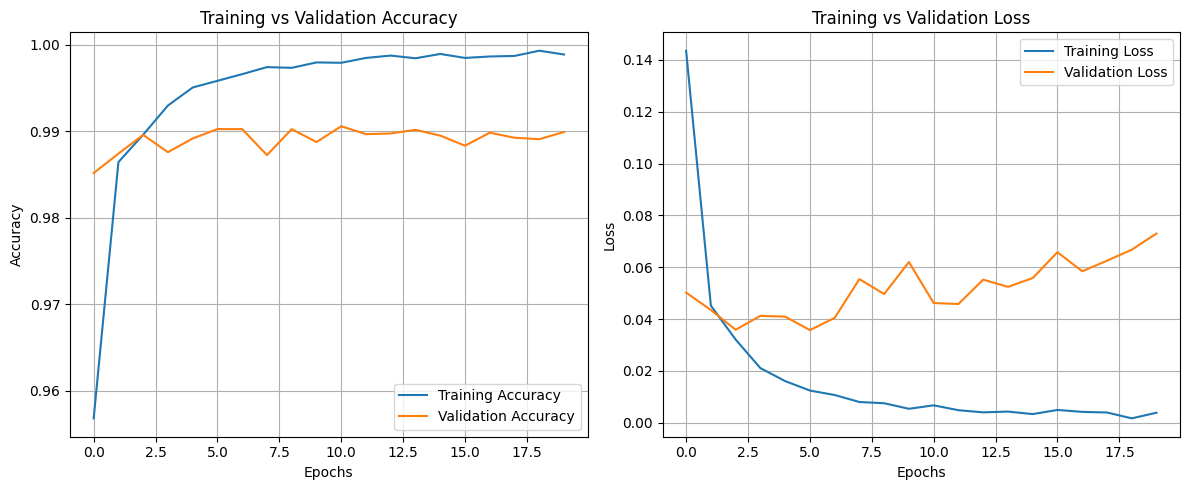

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9993 - loss: 0.0022
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9907 - loss: 0.0647
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9890 - loss: 0.0629

Train Accuracy: 99.93%
Validation Accuracy: 98.99%
Test Accuracy: 99.11%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Confusion Matrix:
 [[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1132    0    1    0    1    0    1    0    0]
 [   2    0 1024    0    0    0    0    6    0    0]
 [   0    1    3  999    0    3    0    2    1    1]
 [   0    0    0    0  975    0    0    0    0    7]
 [   1    0    0    4    0  885    1    0    1    0]
 [   4    5    1    0    2    4  940    0    2    0]
 [   0    2    2    0    0    0    0 1021    1    2]
 [   2    0    3    1    0    1    0    2  962    3]
 [   0    0    1    0    2    4    0    5    1  996]]
Accuracy Score: 99.11%

Classification Report:
               precision    recall  f1-score   support

   

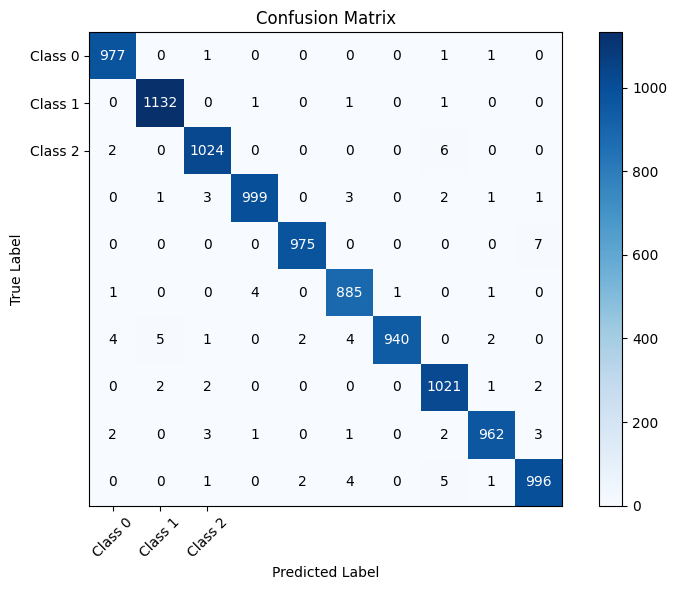

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Assuming you've already trained your model like this:
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, ...)

# 1. Accuracy and Loss Plots
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Evaluate on datasets
train_loss, train_acc = model.evaluate(X_train, y_train)
val_loss, val_acc = model.evaluate(X_val, y_val)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"\nTrain Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# 3. Predict and evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test  # Assuming labels are NOT one-hot encoded

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Accuracy Score
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {acc * 100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", report)

# Class names (update as needed)
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names

# 4. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
model.save("../noise_reduction_model.h5")

In [ ]:
from tensorflow.keras.models import model_from_json
model_in_json = model.to_json()

# Save the JSON to a file
with open('noise_reduction_model.json', 'w') as json_file:
    json_file.write(model_in_json)
